In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38081/status,
Dashboard: /proxy/38081/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37075,Workers: 4
Dashboard: /proxy/38081/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34143,Total threads: 4
Dashboard: /proxy/41237/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:43565,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')

start_time = '2150-01-01' 
end_time   = '2159-12-31'

lat_slice  = slice(-80,-59)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

# Load model data

In [5]:
salt_con = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

In [6]:
# select out bottom values:
depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

In [7]:
bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

2023-04-11 12:25:47,870 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-11 12:25:53,485 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-11 12:25:59,463 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [19]:
import gsw

In [20]:
p = gsw.p_from_z(-salt_con['st_ocean'], salt_con['yt_ocean'])

In [26]:
SA = gsw.SA_from_SP(bottom_salt_con,p[-1,:],bottom_salt_con['xt_ocean'],bottom_salt_con['yt_ocean'])

In [8]:
temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)-273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

2023-04-11 12:26:14,253 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-11 12:26:15,510 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-11 12:26:15,982 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


In [9]:
bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

2023-04-11 12:27:09,020 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-11 12:27:14,396 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-11 12:27:20,280 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-11 12:27:25,948 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-11 12:27:31,845 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-11 12:27:38,080 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-11 12:27:44,462 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-11 12:27:50,911 - distributed.utils_perf - WARNING - full garbage collections took

## Load Schmidtko data

In [10]:
# this is actually ASBW despite the naming:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
salt_Schmidtko = Schmidtko_data.AS

# concat observations onto model grid.
x = temp_Schmidtko.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
temp_Schmidtko['lon'] = x
salt_Schmidtko['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
temp_Schmidtko = xr.concat((temp_Schmidtko[:,321:], temp_Schmidtko[:,:321]), dim='lon')
salt_Schmidtko = xr.concat((salt_Schmidtko[:,321:], salt_Schmidtko[:,:321]), dim='lon')

In [11]:
# interpolate obs onto model grid:

def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

temp_Schmidtko = interp_obs(temp_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)
salt_Schmidtko = interp_obs(salt_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)

# Plot

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
# Figure path
# Panel labels
panel_name = ['a)', 'b)', 'c)', 'd)']
# Font size
plt.rcParams['font.size'] = 18
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [14]:
contour_data  = np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
contour_mask_numbered = contour_data['contour_mask_numbered']
contour_1000m = np.where(contour_mask_numbered == 0, contour_mask_numbered, 1000)
contour_xt_ocean = contour_data['xt_ocean']
contour_yt_ocean = contour_data['yt_ocean']

In [15]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [16]:
bottom_temp_con_m, shelf_mask = shelf_mask_isobath(bottom_temp_con)

In [30]:
bottom_salt_con_m, shelf_mask = shelf_mask_isobath(SA)

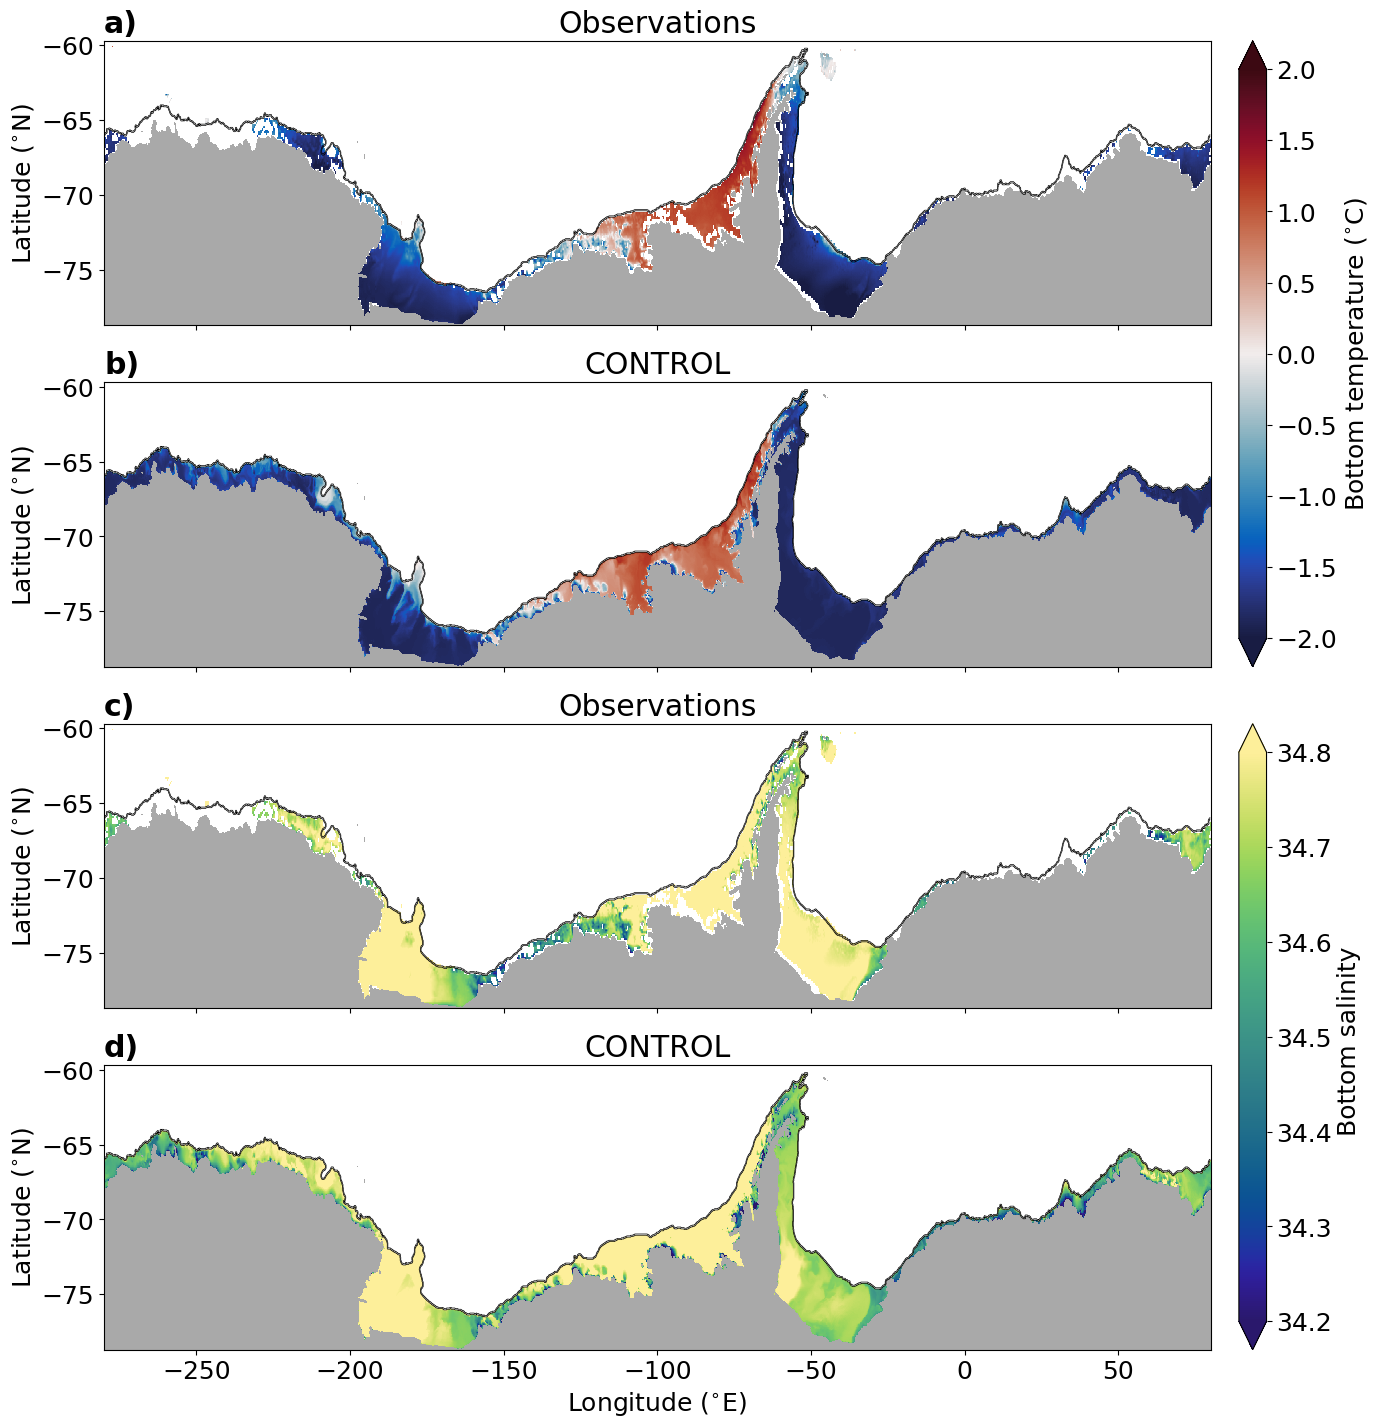

In [31]:
fig = plt.figure(figsize=(15, 17))
# Panel title
title_name = ['Observations', 'CONTROL', 'Observations', 'CONTROL']
# Subplots grid
gs  = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 0.025], wspace=0.05)

# Define subplot, add panel title and label
def plot_land():
    ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
    ax.set_xlim([-280, 80])
    ax.set_ylim([-78.7, -59.7])
    # Add land 
    ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    ax.contour(contour_xt_ocean, contour_yt_ocean, contour_1000m, [1000],colors='k', linewidths=0.5)

for ii in range(4):
    if ii == 0:
        ax = fig.add_subplot(gs[ii])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(temp_Schmidtko.xt_ocean, temp_Schmidtko.yt_ocean, temp_Schmidtko, cmap=cmocean.balance, vmin=-2, vmax=2) 
    elif ii == 1:
        ax = fig.add_subplot(gs[ii+1])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_con_m, cmap=cmocean.balance, vmin=-2, vmax=2) 
    elif ii == 2:
        ax = fig.add_subplot(gs[ii+2])
        ax.set_title(title_name[ii])
        plot_land()
        CF = ax.pcolormesh(salt_Schmidtko.xt_ocean, salt_Schmidtko.yt_ocean, salt_Schmidtko, cmap=cmocean.haline, vmin=34.2, vmax=34.8) 
    elif ii == 3:
        # Salt, WIND-
        ax = fig.add_subplot(gs[ii+3])
        ax.set_title(title_name[ii])
        plot_land()
        CF = ax.pcolormesh(bottom_salt_con_m.xt_ocean, bottom_salt_con_m.yt_ocean, bottom_salt_con_m, cmap=cmocean.haline, vmin=34.2, vmax=34.8) 
        plt.xlabel('Longitude ($^{\circ}$E)')
    plt.ylabel('Latitude ($^{\circ}$N)')
    if ii < 3:
        plt.tick_params(labelbottom=False)
        
# Add colorbars
cbar_ax = fig.add_subplot(gs[0:2, -1])
cbar = plt.colorbar(cf, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Bottom temperature ($^{\circ}$C)')
cbar_ax = fig.add_subplot(gs[2:, -1])
cbar = plt.colorbar(CF, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Bottom salinity ')

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'SuppFig2_Bottom_TS_obs.png'
    plt.savefig(fig_name, bbox_inches = 'tight')